# Harmonic Tidal Analysis - Seattle NOAA Station

## The project!

This short project analyses 4 months of real water level from a Seattle NOAA station to fit a harmonic tidal model and investigate outliers of the model. We use harmonic anlaysis to decopmose the tidal data into its 'constituent astronomical components' $M_1, S_1, K_1$ (more on this later) and examine how well this physics centered approach fits real data.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Loading data:

We have 4 CSVs from NOAA's IOOS system covering May-August 2025 Seattle with 6-minute interval water level measurements. Lets load to a pandas dataframe!

In [9]:

# May 2025 -> August 2025!
files = [
    "data/IOOS_Raw_Water_Level_202505.csv",
    "data/IOOS_Raw_Water_Level_202506.csv", 
    "data/IOOS_Raw_Water_Level_202507.csv",
    "data/IOOS_Raw_Water_Level_202508.csv"
]


dfs = []
for file in files:
    df_month = pd.read_csv(file, parse_dates=["time"], skiprows=[1]) # row 1 is units 
    dfs.append(df_month)

df = pd.concat(dfs, ignore_index = True)
df

,time,WL_VALUE,latitude,longitude,STATION_ID,DATUM
0,2025-05-01 00:00:00+00:00,3.779,47.6026,-122.3393,9447130,MSL
1,2025-05-01 00:06:00+00:00,3.876,47.6026,-122.3393,9447130,MSL
2,2025-05-01 00:12:00+00:00,3.974,47.6026,-122.3393,9447130,MSL
3,2025-05-01 00:18:00+00:00,4.062,47.6026,-122.3393,9447130,MSL
4,2025-05-01 00:24:00+00:00,4.153,47.6026,-122.3393,9447130,MSL
...,...,...,...,...,...,...
29514,2025-08-31 23:30:00+00:00,5.056,47.6026,-122.3393,9447130,MSL
29515,2025-08-31 23:36:00+00:00,5.049,47.6026,-122.3393,9447130,MSL
29516,2025-08-31 23:42:00+00:00,5.040,47.6026,-122.3393,9447130,MSL
29517,2025-08-31 23:48:00+00:00,5.034,47.6026,-122.3393,9447130,MSL


#### We can see from above there is: time of measurement, WL_VALUE is tide height in meters, and the rest we dont need (maye for a future project...)

#### It seems sorted in time and without NAs but just to be sure:

In [12]:
df = df.dropna(subset=["time", "WL_VALUE"])
df["WL_VALUE"] = pd.to_numeric(df["WL_VALUE"], errors="coerce")
df = df.dropna(subset=["WL_VALUE"])
df

,time,WL_VALUE,latitude,longitude,STATION_ID,DATUM
0,2025-05-01 00:00:00+00:00,3.779,47.6026,-122.3393,9447130,MSL
1,2025-05-01 00:06:00+00:00,3.876,47.6026,-122.3393,9447130,MSL
2,2025-05-01 00:12:00+00:00,3.974,47.6026,-122.3393,9447130,MSL
3,2025-05-01 00:18:00+00:00,4.062,47.6026,-122.3393,9447130,MSL
4,2025-05-01 00:24:00+00:00,4.153,47.6026,-122.3393,9447130,MSL
...,...,...,...,...,...,...
29514,2025-08-31 23:30:00+00:00,5.056,47.6026,-122.3393,9447130,MSL
29515,2025-08-31 23:36:00+00:00,5.049,47.6026,-122.3393,9447130,MSL
29516,2025-08-31 23:42:00+00:00,5.040,47.6026,-122.3393,9447130,MSL
29517,2025-08-31 23:48:00+00:00,5.034,47.6026,-122.3393,9447130,MSL


### Now lets convert to time series pandas

In [17]:
s_6min = df.set_index("time")["WL_VALUE"].astype(float).sort_index()
s_hour = s_6min.resample("1h").mean()

print("Coverage:", s_6min.index.min(), "→", s_6min.index.max())
print("Data points:", len(s_6min), "6-min intervals |", len(s_hour), "hourly points")


print("\nData quality checks:")

# 6 minute interval check
diff = s_6min.index.to_series().diff().value_counts().head()
print("Top time intervals:")
print(diff)
print("(Should be mostly 00:06:00 for 6-minute data)")

# Make sure all data is from same station and datum
print(f"\nStations: {df['STATION_ID'].dropna().unique()}")
print(f"Datum: {df['DATUM'].dropna().unique()}")
print("(Should be single station and datum for consistent analysis)")


Coverage: 2025-05-01 00:00:00+00:00 → 2025-08-31 23:54:00+00:00
Data points: 29519 6-min intervals | 2952 hourly points

Data quality checks:
Top time intervals:
time
0 days 00:06:00    29517
0 days 00:12:00        1
Name: count, dtype: int64
(Should be mostly 00:06:00 for 6-minute data)

Stations: [9447130]
Datum: ['MSL']
(Should be single station and datum for consistent analysis)


## okay looks all good (with one 12 minute gap) Let's plot the tide vs date:


Water level range: 1.215 to 6.247 meters
Mean: 4.459, Std: 1.124


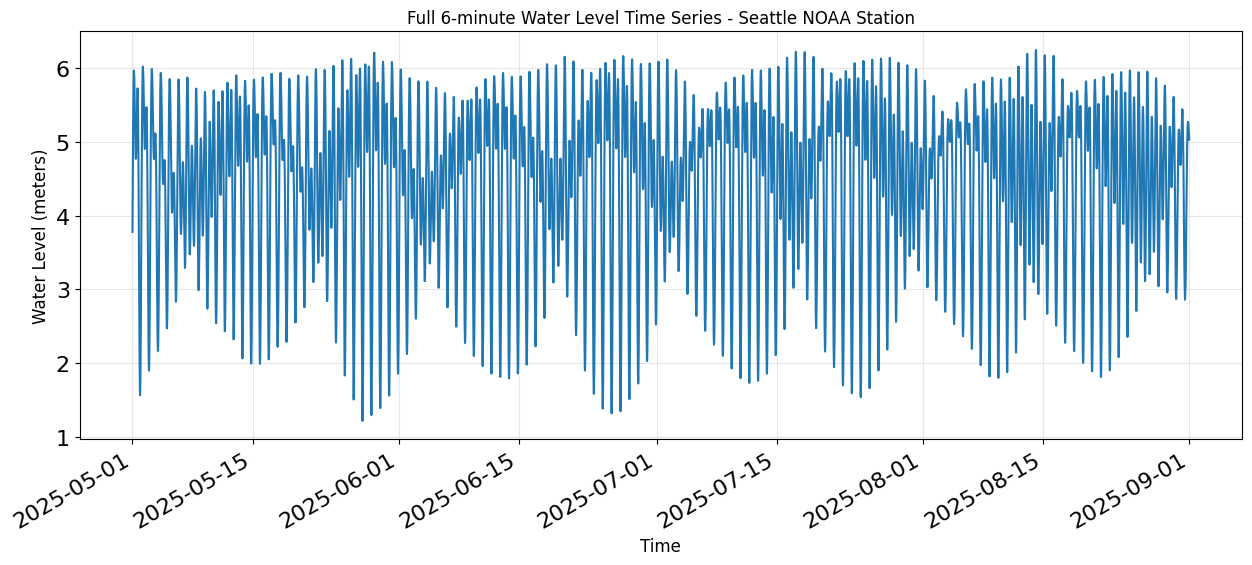

In [20]:
print(f"Water level range: {s_6min.min():.3f} to {s_6min.max():.3f} meters")
print(f"Mean: {s_6min.mean():.3f}, Std: {s_6min.std():.3f}")

plt.figure(figsize=(15, 6))
# using pandas time series .plot
s_6min.plot(title="Full 6-minute Water Level Time Series - Seattle NOAA Station", fontsize= 16)
plt.ylabel("Water Level (meters)", fontsize = 12)
plt.xlabel("Time", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## cool! Can see the sinusoidal patterns, Let's group by time of Day:

Sample of time-of-day statistics:
             count  median   mean    std     p5    p95
time_of_day                                           
0.0            123   4.776  4.561  0.988  2.745  5.796
0.1            123   4.769  4.594  0.980  2.760  5.788
0.2            123   4.800  4.626  0.972  2.769  5.788
0.3            123   4.832  4.658  0.964  2.780  5.812
0.4            123   4.846  4.689  0.956  2.827  5.830
0.5            123   4.846  4.720  0.948  2.887  5.842
0.6            123   4.933  4.751  0.939  2.932  5.855
0.7            123   4.951  4.780  0.931  2.923  5.870
0.8            123   4.970  4.809  0.923  2.918  5.882
0.9            123   5.023  4.837  0.914  2.973  5.885

We have 240 unique times of day (should be 240 for 6-min intervals)


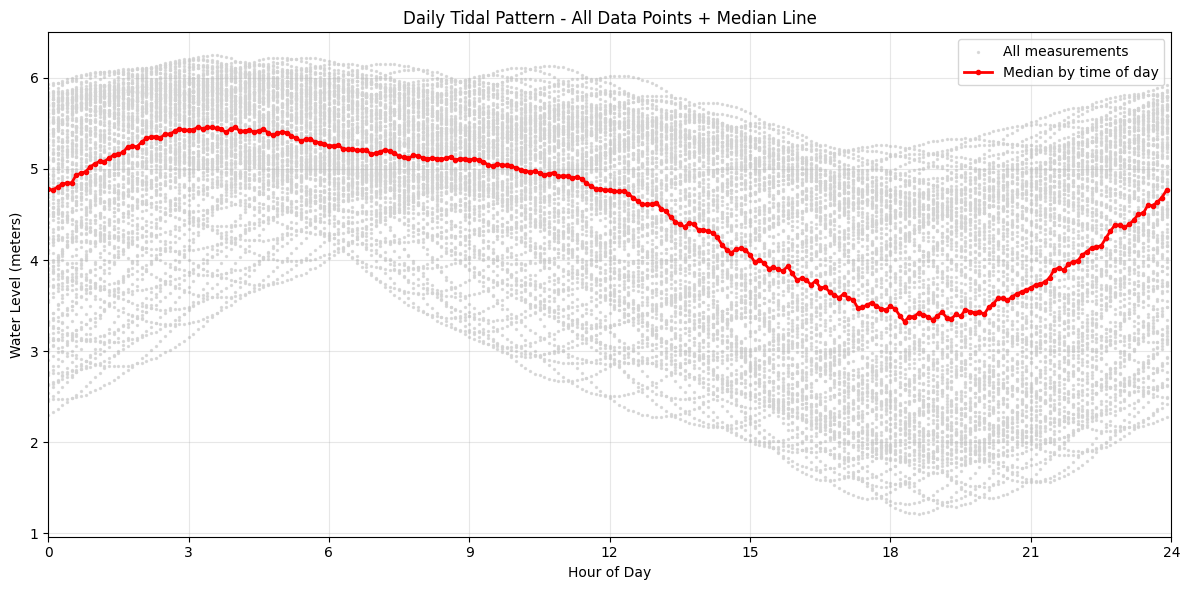

In [23]:
df_analysis = s_6min.reset_index()
df_analysis['hour'] = df_analysis['time'].dt.hour
df_analysis['minute'] = df_analysis['time'].dt.minute
df_analysis['time_of_day'] = df_analysis['hour'] + df_analysis['minute']/60

time_stats = df_analysis.groupby('time_of_day')['WL_VALUE'].agg([
    'count', 'median', 'mean', 'std',
    lambda x: x.quantile(0.05),  # 5th percentile
    lambda x: x.quantile(0.95)   # 95th percentile
]).round(3)

time_stats.columns = ['count', 'median', 'mean', 'std', 'p5', 'p95']

print("Sample of time-of-day statistics:")
print(time_stats.head(10))
print(f"\nWe have {len(time_stats)} unique times of day (should be 240 for 6-min intervals)")

plt.figure(figsize=(12, 6))

plt.scatter(df_analysis['time_of_day'], df_analysis['WL_VALUE'], 
           c='lightgray', alpha=0.8, s=1.9, label='All measurements')

plt.plot(time_stats.index, time_stats['median'], 'ro-', 
         linewidth=2, markersize=3, label='Median by time of day')

plt.title('Daily Tidal Pattern - All Data Points + Median Line')
plt.xlabel('Hour of Day')
plt.ylabel('Water Level (meters)')
plt.xlim(0, 24)
plt.xticks(range(0, 25, 3))  # Every 3 hours
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Very cool! 1 More plot before fitting... Lets do a zoom in on the first two weeks:

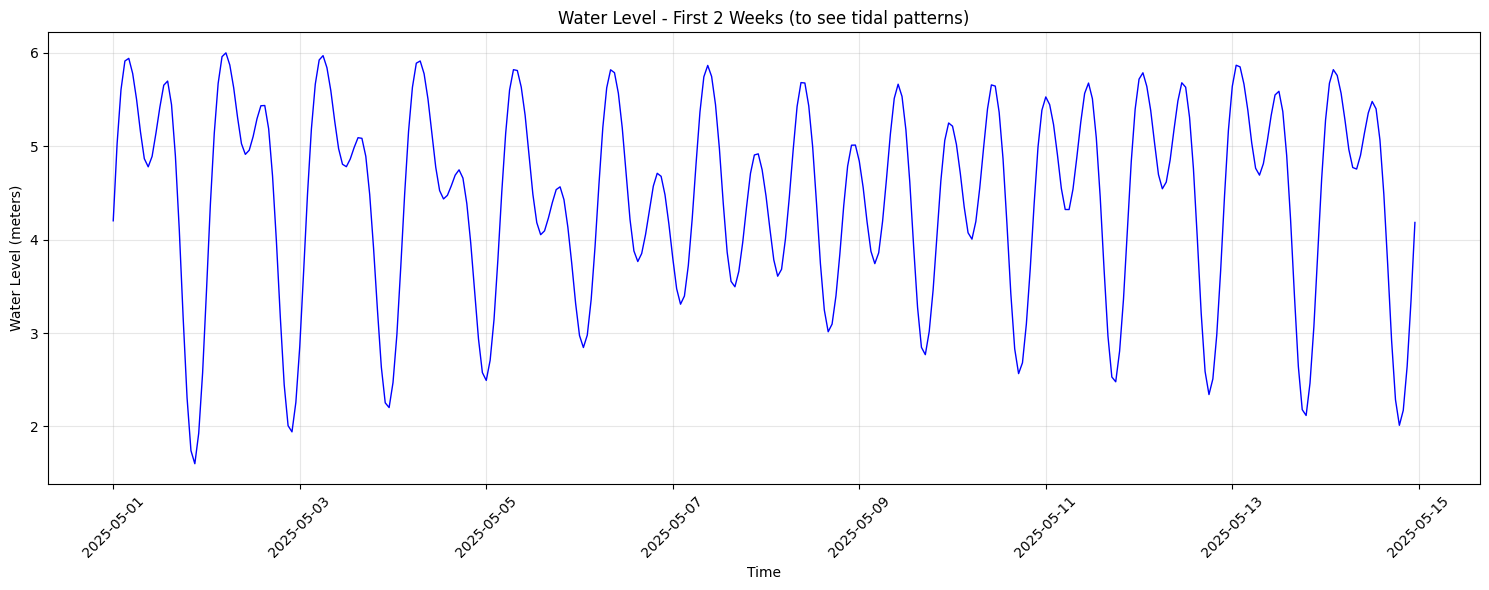

In [25]:
# Let's first plot a shorter time window to see the tidal patterns clearly
plt.figure(figsize=(15, 6))

# Plot just 2 weeks to see the patterns
two_weeks = s_hour.head(24*14)  # First 14 days
plt.plot(two_weeks.index, two_weeks.values, 'b-', linewidth=1)


plt.title('Water Level - First 2 Weeks (to see tidal patterns)')
plt.xlabel('Time')
plt.ylabel('Water Level (meters)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Sure Looks like a sum of sinuisoidal curves!

Now for the physics. 

### Harmonic Tidal Thoery 

Tides can be modeled from a sum of sine waves where each wave represents a differnet astronomical 'forcing' - the moon and sun pulling on oceans from different angles and distances.

The water level can be modeled using these sinusoidal components like:

$$\text{Water Level}(t) = \text{Mean} + \sum_{i} A_i \cos\left(\frac{2\pi}{T_i} t + \phi_i\right)$$

Where $T_i$ is the period of each contituent, $A_i is the amplitude, and $\phi_i$ is the phase.

There are many constituents, but we will the following 6 that have short periods that can be fit with our 4-month data and are known(?) to be strong in the Pacific Coast. Also Diurnal - one period per day. Semi-diurnal twice per day

**The 6 major constituents come from:**
- **M2 (12.42h)**: Principal lunar semi-diurnal - Earth's rotation relative to moon
- **S2 (12.00h)**: Principal solar semi-diurnal - Earth's rotation relative to sun  
- **N2 (12.66h)**: Lunar elliptic semi-diurnal - moon's elliptical orbit variations
- **K1 (23.93h)**: Lunar diurnal - moon's declination (north-south position)
- **O1 (25.82h)**: Lunar diurnal - combined moon declination and orbit effects
- **P1 (24.07h)**: Solar diurnal - sun's declination variations

Taken from page 98 of https://tidesandcurrents.noaa.gov/publications/Tidal_Analysis_and_Predictions.pdf

Theese periods are fixed by celesital mechanics.  Only $A_i$ and $\phi_i$  very by location.

So essentially we will be summing the following sinuisodal and fitting the amplitude $A_i$ and $\phi_i$ to the Seattle Tidal data while fixing the $T_i$ to the NOAA values. The following plots the periods of the 6 major Tidal Constituents

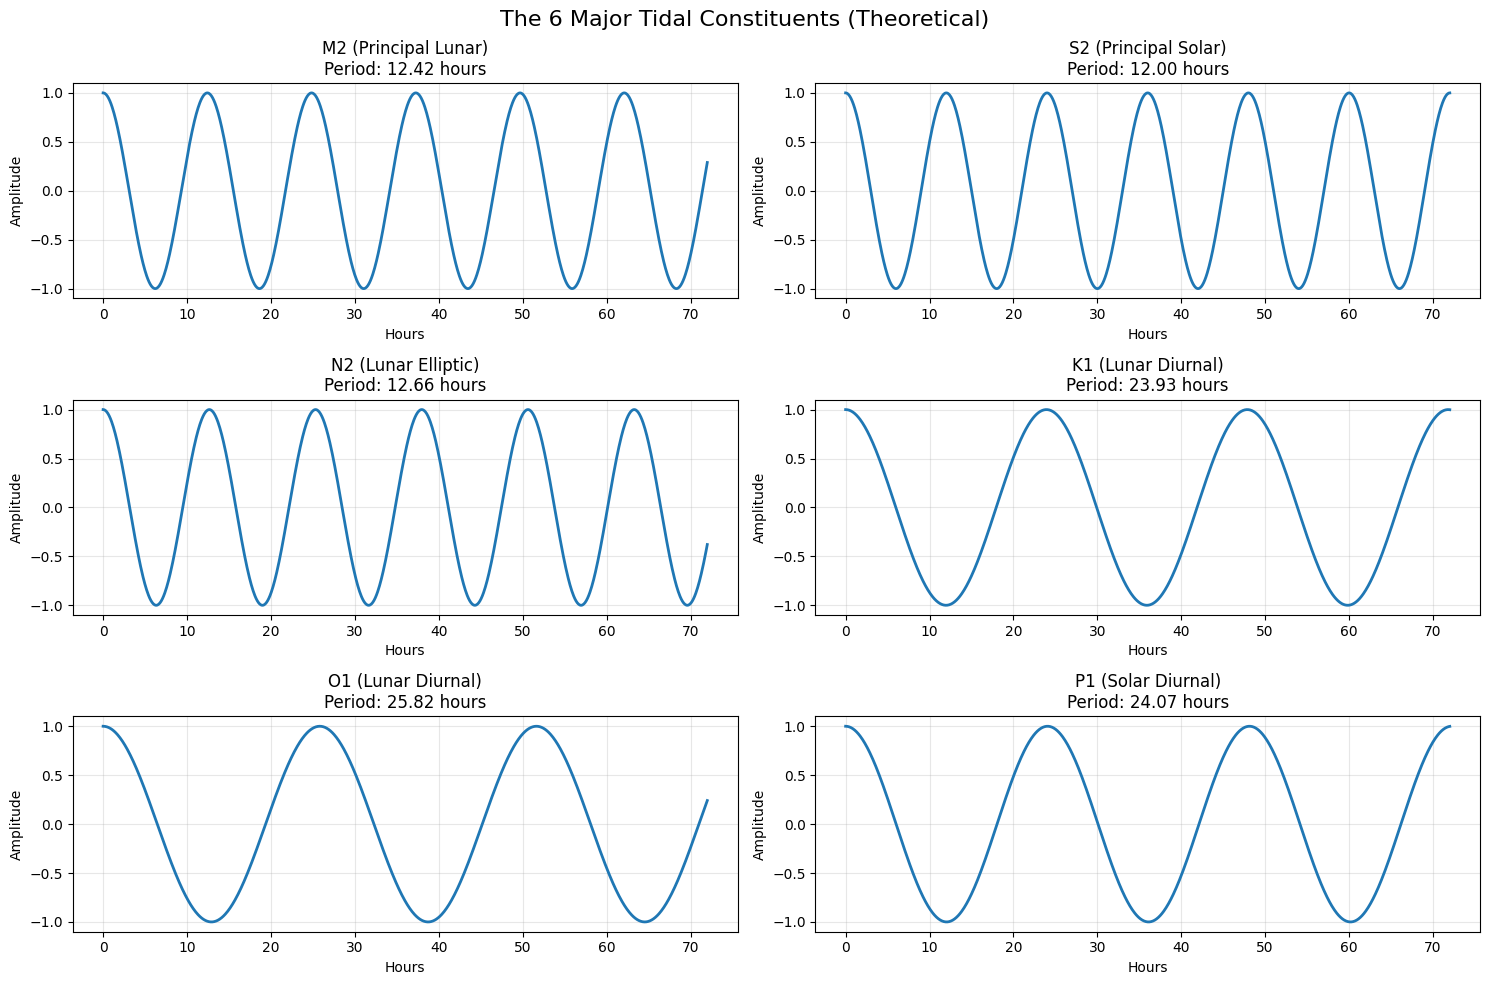

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('The 6 Major Tidal Constituents (Period compairons)', fontsize=16)

t_hours = np.linspace(0, 72, 1000)  # 3 days

constituents = {
    'M2 (Principal Lunar)': 12.421,
    'S2 (Principal Solar)': 12.000, 
    'N2 (Lunar Elliptic)': 12.658,
    'K1 (Lunar Diurnal)': 23.934,
    'O1 (Lunar Diurnal)': 25.819,
    'P1 (Solar Diurnal)': 24.066
}

for i, (name, period) in enumerate(constituents.items()):
    row, col = i // 2, i % 2
    omega = 2 * np.pi / period
    wave = np.cos(omega * t_hours)
    
    axes[row, col].plot(t_hours, wave, linewidth=2)
    axes[row, col].set_title(f'{name}\nPeriod: {period:.2f} hours')
    axes[row, col].set_xlabel('Hours')
    axes[row, col].set_ylabel('Amplitude')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Okay now for the fit:
We will use scipy's curve_fit to fit the amplitude and phase of the 6 constituents as well as the mean tidal height per hour leaving 13 parameters.

Specifically curve_fit utses least squares optimiazation or finds the 13 paramteres that minize the sum of squared differences between model predictions  and the **hourly averageed** water levels.Each hour's data point is an average of ~10 six-minute measurements from that hour noise 

In [32]:
from scipy.optimize import curve_fit

# 6-constituent harmonic model
def tidal_model(t_hours, mean, A_M2, phi_M2, A_S2, phi_S2, A_N2, phi_N2, 
                A_K1, phi_K1, A_O1, phi_O1, A_P1, phi_P1):
    """
    Harmonic tidal model with 6 constituents
    13 parameters total: 1 mean + 6 amplitudes + 6 phases
    """
    periods = {
        'M2': 12.421, 'S2': 12.000, 'N2': 12.658,
        'K1': 23.934, 'O1': 25.819, 'P1': 24.066
    }
    
    # to angular frequencies
    omega_M2 = 2 * np.pi / periods['M2']
    omega_S2 = 2 * np.pi / periods['S2'] 
    omega_N2 = 2 * np.pi / periods['N2']
    omega_K1 = 2 * np.pi / periods['K1']
    omega_O1 = 2 * np.pi / periods['O1']
    omega_P1 = 2 * np.pi / periods['P1']
    
    # mean, sum of all constituents
    result = (mean + 
              A_M2 * np.cos(omega_M2 * t_hours + phi_M2) +
              A_S2 * np.cos(omega_S2 * t_hours + phi_S2) +
              A_N2 * np.cos(omega_N2 * t_hours + phi_N2) +
              A_K1 * np.cos(omega_K1 * t_hours + phi_K1) +
              A_O1 * np.cos(omega_O1 * t_hours + phi_O1) +
              A_P1 * np.cos(omega_P1 * t_hours + phi_P1))
    
    return result

# using hours
t0 = s_hour.index[0]
t_hours = (s_hour.index - t0).total_seconds() / 3600
water_levels = s_hour.values

# Initial parameter guess: [mean, A1, phi1, A2, phi2, ...]
p0 = [s_hour.mean(),  # mean
      0.5, 0,         # M2 amplitude, phase
      0.3, 0,         # S2 amplitude, phase  
      0.2, 0,         # N2 amplitude, phase
      0.4, 0,         # K1 amplitude, phase
      0.3, 0,         # O1 amplitude, phase
      0.1, 0]         # P1 amplitude, phase

print("Starting harmonic fit...")
print(f"Data points: {len(water_levels)}")
print(f"Time span: {t_hours[-1]:.1f} hours ({t_hours[-1]/24:.1f} days)")

# fit the model
popt, pcov = curve_fit(tidal_model, t_hours, water_levels, p0=p0)

print("Fit completed!")
print(f"Mean water level: {popt[0]:.3f} meters")

Starting harmonic fit...
Data points: 2952
Time span: 2951.0 hours (123.0 days)
Fit completed!
Mean water level: 4.456 meters


Now that the fit is complete I will make a figure of 3 plots.

- **Top plot** is the observed water level (hourly average) vs the predicted harmoinc fit water level for the first 30 days to see how well the model captures tidal cycles.
- **Middle Plot** shows the residual between the hourly averaged tidal hieghts and model predictions over the full 4 months. Important to look for patterns in the residuals demosntrating what the tidal 
- **Bottom plot:** Bar chart of the fitted amplitudes for each of the 6 tidal constituents, showing relative importance

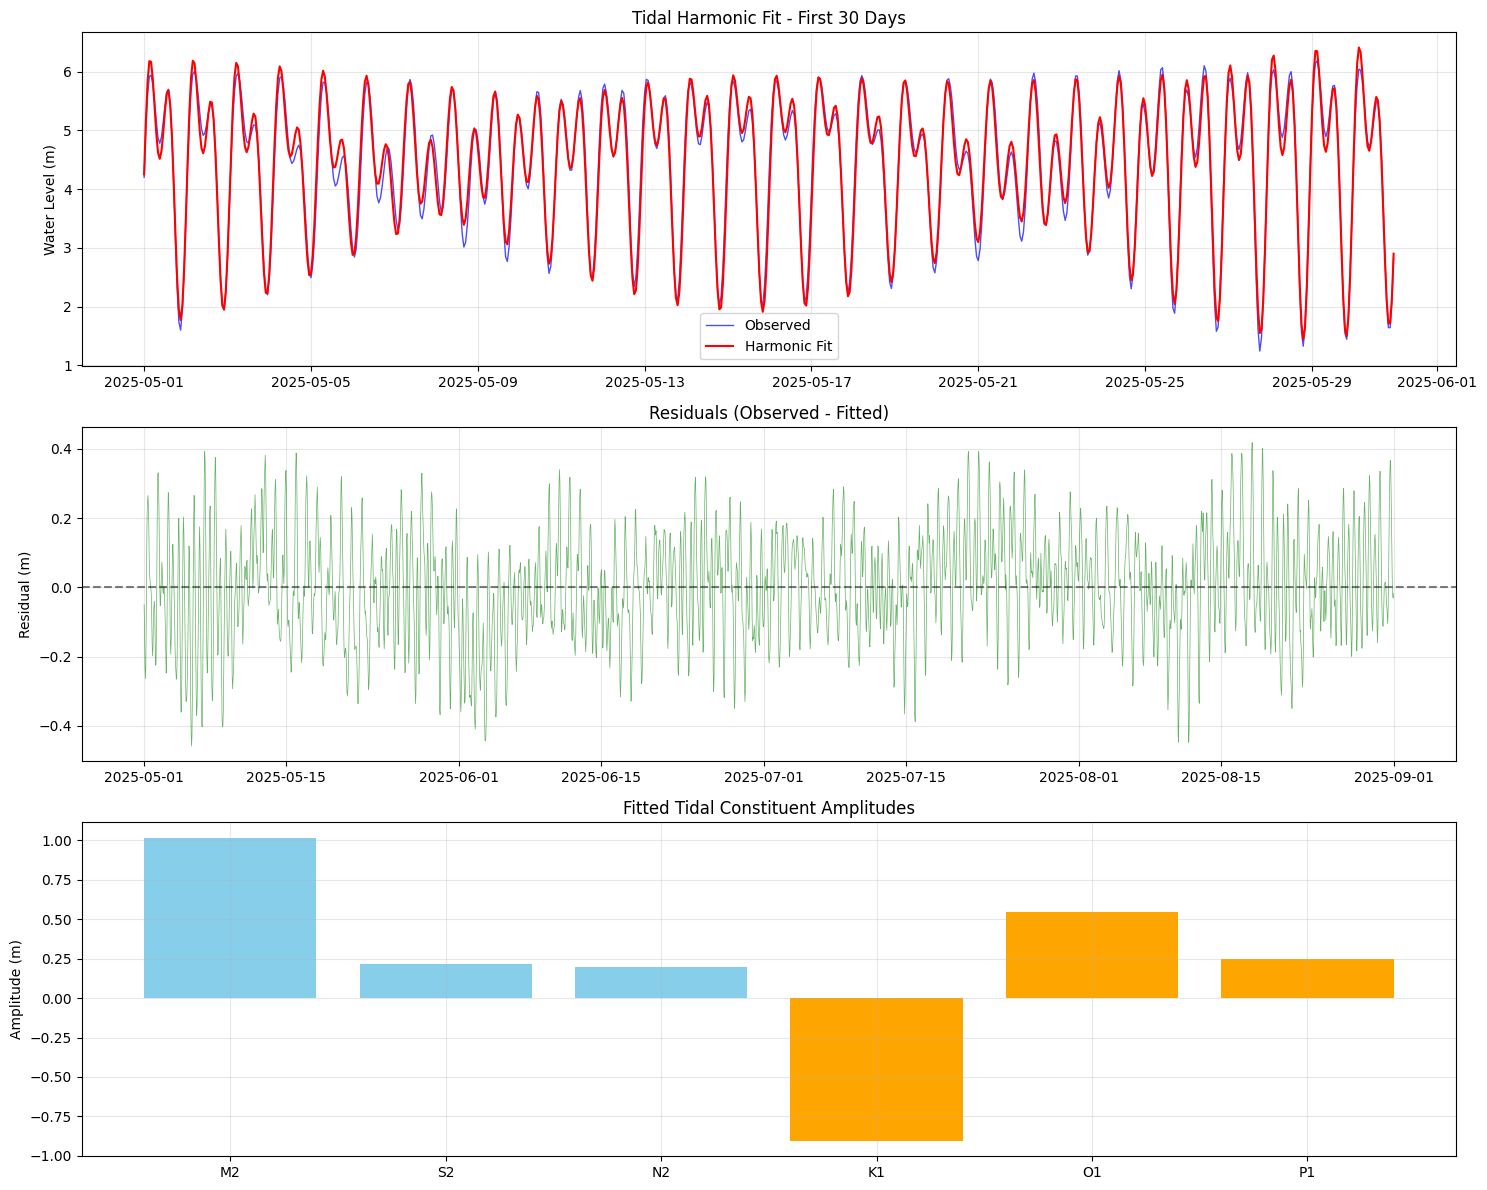

Root Mean Square Error: 0.152 meters
R² (explained variance): 0.982


In [33]:
fitted_values = tidal_model(t_hours, *popt)
residuals = water_levels - fitted_values

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# plot 1: Observed vs Fitted (first 30 days)
days_to_show = 30
end_idx = min(24 * days_to_show, len(s_hour))
time_subset = s_hour.index[:end_idx]
obs_subset = water_levels[:end_idx]
fit_subset = fitted_values[:end_idx]

axes[0].plot(time_subset, obs_subset, 'b-', alpha=0.7, linewidth=1, label='Observed')
axes[0].plot(time_subset, fit_subset, 'r-', linewidth=1.5, label='Harmonic Fit')
axes[0].set_title(f'Tidal Harmonic Fit - First {days_to_show} Days')
axes[0].set_ylabel('Water Level (m)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# plot 2: Residuals (observed - fitted)
axes[1].plot(s_hour.index, residuals, 'g-', alpha=0.6, linewidth=0.5)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_title('Residuals (Observed - Fitted)')
axes[1].set_ylabel('Residual (m)')
axes[1].grid(True, alpha=0.3)

# plot 3: Constituent amplitudes
constituent_names = ['M2', 'S2', 'N2', 'K1', 'O1', 'P1']
amplitudes = [popt[1], popt[3], popt[5], popt[7], popt[9], popt[11]]
axes[2].bar(constituent_names, amplitudes, color=['skyblue']*3 + ['orange']*3)
axes[2].set_title('Fitted Tidal Constituent Amplitudes')
axes[2].set_ylabel('Amplitude (m)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


rmse = np.sqrt(np.mean(residuals**2))
print(f"Root Mean Square Error: {rmse:.3f} meters")
print(f"R² (explained variance): {1 - np.var(residuals)/np.var(water_levels):.3f}")

## Results and Analysis

From the three plots we can see:

**Top plot (Fit Quality):** The harmonic model captures the main tidal oscillations reasonably well, but there appears to be some systematic mismatch - sinusoidal drift over the 30 day period.

**Middle plot (Residuals):** The residuals clearly show they are NOT random noise around zero. Instead, there's a distinct sinusoidal pattern with what appears to be a ~30-day period. This systematic pattern suggests our 6-constituent model is missing longer-period tidal components.

**Bottom plot (Constituent Strengths):** M2 (principal lunar) dominates at ~1.0m amplitude, followed by K1 (lunar diurnal) at 0.9m magnitude. This confirms Seattle has mixed semi-diurnal tides - both twice-daily and once-daily components are significant.

**The smoking gun:** That organized residual pattern suggests we're missing monthly and fortnightly tidal constituents like:
- **Mf (14.77 days):** Fortnightly tide from lunar orbit variations
- **Mm (27.55 days):** Monthly tide from lunar distance changes

With only 4 months of data, we have limited ability to resolve these longer periods, but the residual pattern suggests they're present and measurable. Future work should focus on gathering data froma larger time window to feet these additional constituents , and possibly compare other sites geographcially close to Seattle

**Model Performance:** The fit statistics show reasonable results with RMSE of 0.152 meters and R² of 0.982, indicating our 6-constituent model explains 98.2% of the tidal variation despite missing the longer-period components.